In [90]:
import gymnasium as gym

In [91]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

In [92]:
import numpy as np

def choose_action_softmax(
        state: int,
        actions: range,
        q: dict,
        temperature: float
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política Softmax.
    """
    # Obtener los valores Q para todas las acciones en el estado actual
    q_values = [q.get((state, a), 0.0) for a in actions]
    
    # Aplicar la política Softmax para calcular las probabilidades de acción
    unscaled_probabilities = np.exp(np.array(q_values) / temperature)
    probabilities = unscaled_probabilities / np.sum(unscaled_probabilities)
    
    # Elegir una acción basada en las probabilidades calculadas
    action = np.random.choice(actions, p=probabilities)
    
    return action


In [93]:
#TANIA
def learn_SARSA(
        state: Any,
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: dict,
        q: dict,
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: Estado actual
        action: Acción tomada en el estado actual
        reward: Recompensa obtenida al realizar la acción
        next_state: Siguiente estado tras la acción
        next_action: Próxima acción a tomar
        hyperparameters: Hiperparámetros del agente (por ejemplo, tasa de aprendizaje)
        q: Diccionario de valores Q (estado-acción)
    """

    # Obtenemos los hiperparámetros relevantes
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Obtenemos el valor Q actual para el par estado-acción actual
    q_current = q.get((state, action), 0.0)

    # Obtenemos el valor Q para el par estado-acción siguiente
    q_next = q.get((next_state, next_action), 0.0)

    # Calculamos la actualización SARSA
    updated_q = q_current + alpha * (reward + gamma * q_next - q_current)

    # Actualizamos el valor Q en el diccionario de valores Q
    q[(state, action)] = updated_q
pass

In [94]:
def learn_Q_learning(
        state: Any,
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: dict,
        q: dict,
) -> None:

    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args:
        state: El estado actual.
        action: La acción tomada en el estado actual.
        reward: La recompensa recibida por tomar la acción en el estado actual.
        next_state: El siguiente estado resultante de tomar la acción.
        next_action: La próxima acción seleccionada en el siguiente estado (según la política utilizada).
        hyperparameters: Un diccionario que contiene hiperparámetros (por ejemplo, alpha, gamma).
        q: Un diccionario que almacena los valores Q, que se actualizará con la nueva estimación.
    """

        # Desempaquetar los hiperparámetros
    alpha = hyperparameters['alpha']  # Tasa de aprendizaje
    gamma = hyperparameters['gamma']  # Factor de descuento

    # Calcular el valor Q actual para el estado-acción actual
    current_q_value = q.get((state, action), 0.0)

    # Calcular el valor Q del mejor estado-acción futuro (Q máximo)
    next_q_values = [q.get((next_state, a), 0.0) for a in action]
    max_next_q_value = max(next_q_values)

    # Aplicar la fórmula de actualización Q-learning
    new_q_value = current_q_value + alpha * (reward + gamma * max_next_q_value - current_q_value)

    # Actualizar el valor Q en el diccionario q
    q[(state, action)] = new_q_value

    pass

In [95]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []
    temperature = hyperparameters['temperature']

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_softmax(
            state, actions, q, temperature)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_softmax(
            state, actions, q, temperature)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [96]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
    "temperature": 0.5
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [97]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q
)

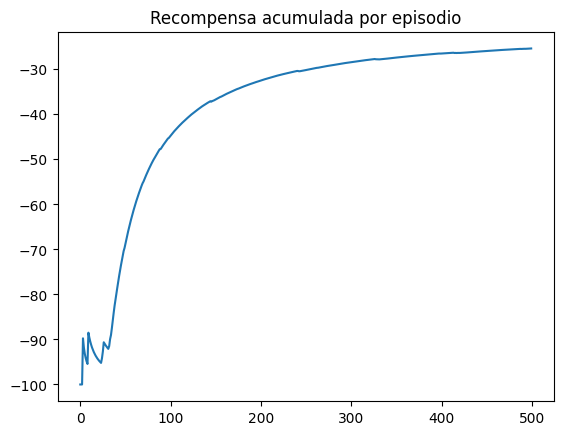

In [98]:
plot_reward_per_episode(reward_ep)

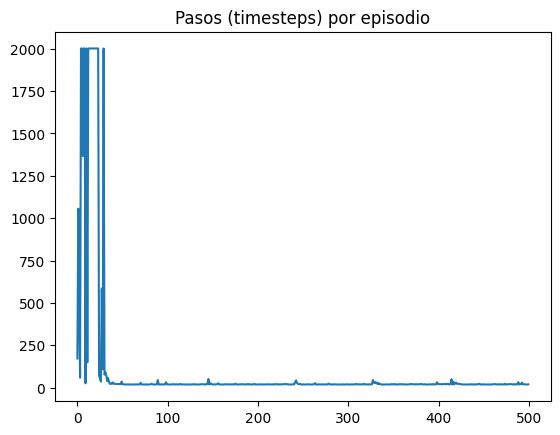

In [99]:
plot_steps_per_episode(timesteps_ep)

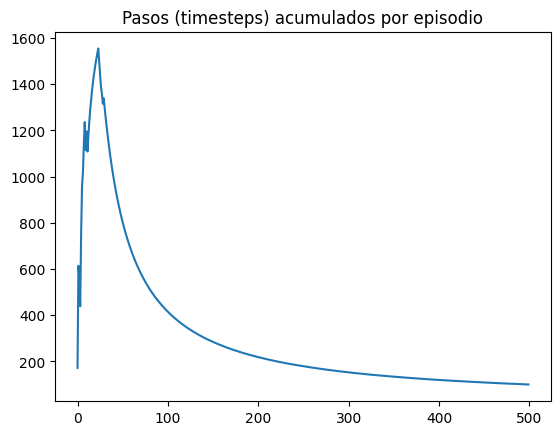

In [100]:
plot_steps_per_episode_smooth(timesteps_ep)

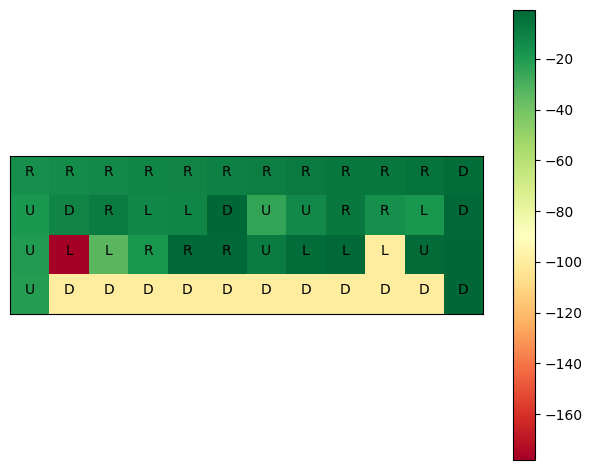


 Matriz de mejor acción-valor (en números): 

 [[ -15.61976423  -14.36635908  -13.29220786  -12.25217928  -11.20416778
   -10.15283251   -9.12903079   -8.17398094   -7.26782734   -6.29440777
    -5.19646514   -3.01563922]
 [ -19.02001682  -11.50583466   -8.56431385  -12.74082756  -12.13192538
    -0.75        -24.45253391  -13.90629477   -7.01583031  -15.95786314
   -18.54837905   -2.00195372]
 [ -20.54667152 -178.03369944  -33.74534098  -18.39482863   -1.5
    -1.6796875    -8.91648425   -3.12905407   -1.64099121 -100.
    -2.70900726   -1.        ]
 [ -21.46293879 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [101]:
draw_value_matrix(q)

In [104]:
#cambiamos algunos hiperparámetros

q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.4,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
    "temperature": 0.4
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [105]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q
)

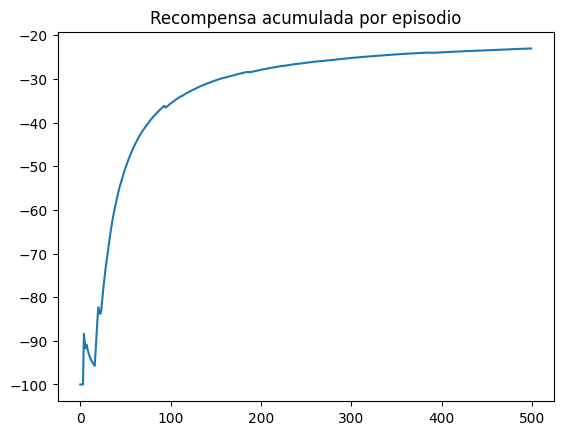

In [106]:
plot_reward_per_episode(reward_ep)

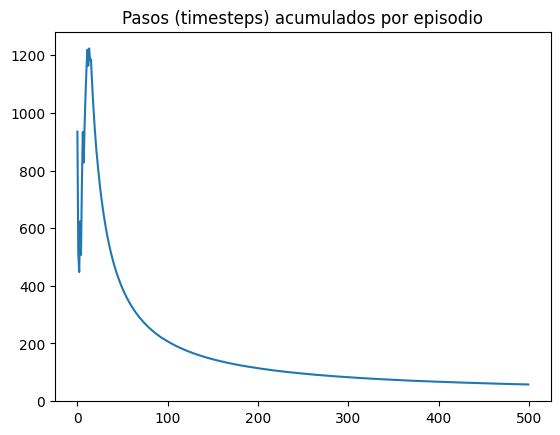

In [107]:
plot_steps_per_episode_smooth(timesteps_ep)

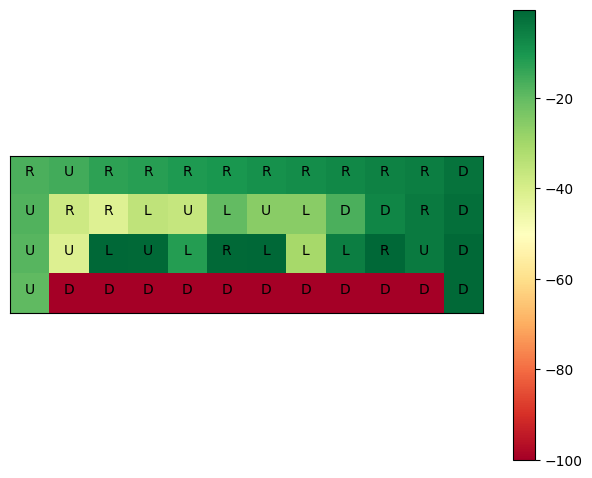


 Matriz de mejor acción-valor (en números): 

 [[ -16.7851465   -15.76911626  -13.2110754   -12.19959894  -11.19043278
   -10.19283057   -9.20743818   -8.21709604   -7.19775193   -6.14415364
    -5.07882917   -3.00712744]
 [ -17.61616887  -38.10015224  -41.94802499  -35.16137785  -36.51550499
   -20.07995268  -26.03323048  -25.91275709  -16.98248733   -6.94248065
    -4.30202075   -2.00078716]
 [ -18.63429468  -41.25400101   -0.4          -0.896       -11.92754452
    -0.9024       -0.4         -30.7035783    -5.12723261   -0.624
    -4.63814712   -1.        ]
 [ -19.67280227 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [108]:
draw_value_matrix(q)

Disminuyendo alfa y la temperatura (estamos usando softmax) la solución encontrada es peor.

In [112]:
#cambiamos algunos hiperparámetros

q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.7,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
    "temperature": 0.8
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
#random_state = np.random.RandomState(42)

In [113]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q
)

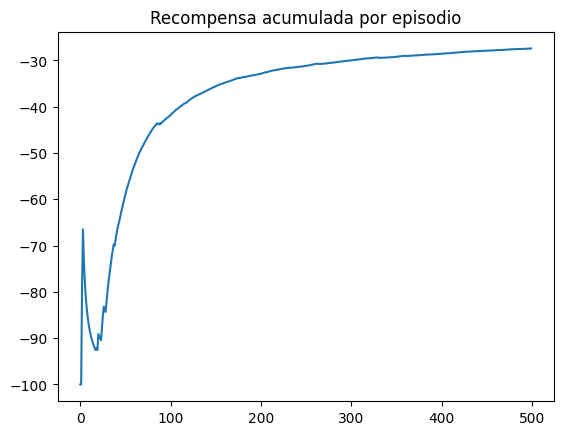

In [114]:
plot_reward_per_episode(reward_ep)

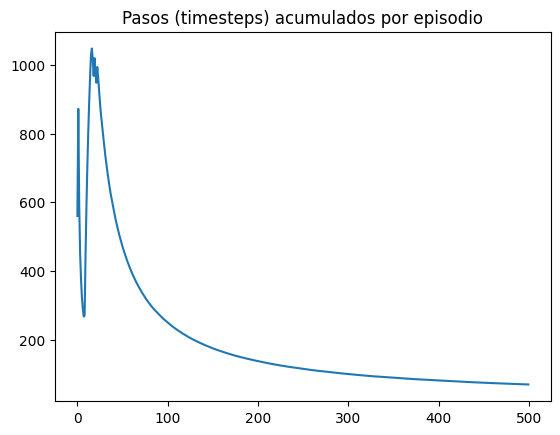

In [115]:
plot_steps_per_episode_smooth(timesteps_ep)

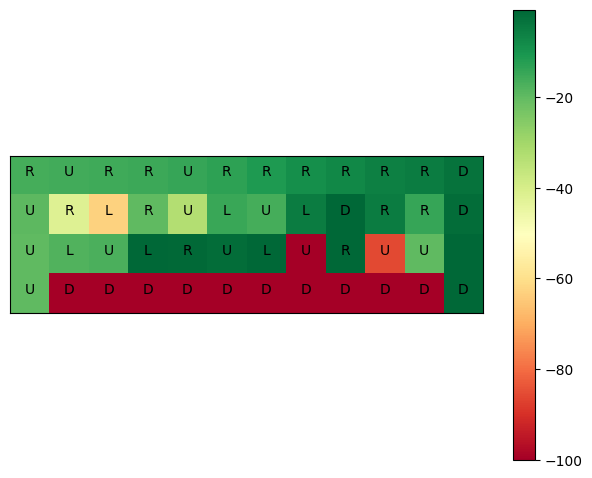


 Matriz de mejor acción-valor (en números): 

 [[ -16.37743987  -15.89541104  -15.47003716  -15.32354137  -14.43357544
   -13.30305261  -11.30176492   -9.08600025   -7.3437643    -6.07911355
    -5.26892485   -3.14073682]
 [ -19.49983964  -42.14512434  -63.14340498  -20.07269185  -33.16094954
   -14.67716984  -16.5663492    -4.98660527   -0.7          -5.3132781
   -14.48426205   -2.02009258]
 [ -19.75054877  -17.86907954  -17.2190799    -0.7          -1.4
    -2.247        -0.7        -100.           -0.7         -85.92027677
   -20.06784477   -1.        ]
 [ -20.01111249 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [116]:
draw_value_matrix(q)

In [117]:
#cambiamos algunos hiperparámetros

q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.7,
    "gamma": 0.5,
    "epsilon": 0.1,
    "tau": 25,
    "temperature": 0.8
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
#random_state = np.random.RandomState(42)

avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q
)



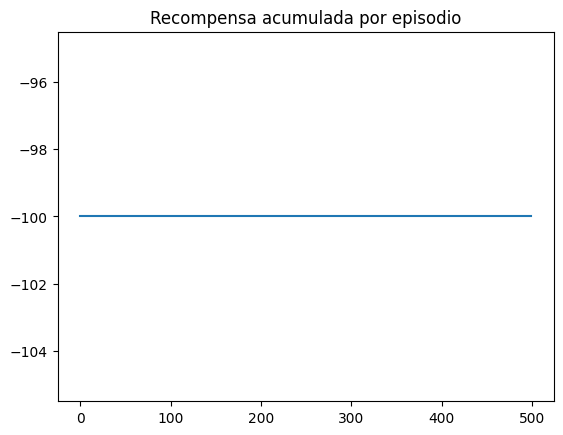

In [118]:
plot_reward_per_episode(reward_ep)

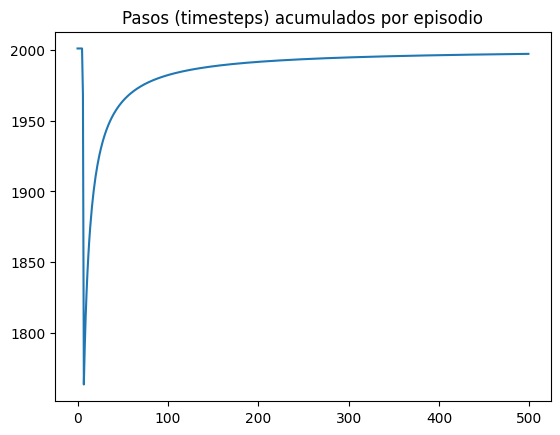

In [119]:
plot_steps_per_episode_smooth(timesteps_ep)

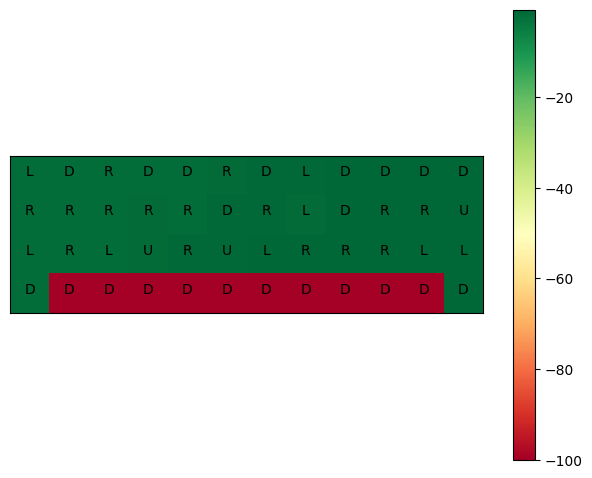


 Matriz de mejor acción-valor (en números): 

 [[  -2.01486001   -2.03705446   -2.01375129   -1.89263488   -1.97824972
    -1.76380334   -1.302        -1.43185      -0.7          -0.7
    -0.7          -0.7       ]
 [  -2.02370742   -2.04057214   -2.05831491   -1.77402908   -1.94725584
    -1.4516425    -1.24075      -1.66289754   -0.7          -0.7
    -0.7          -0.7       ]
 [  -1.96051238   -1.92164017   -1.89572271   -1.60457799   -1.2285
    -1.14540351   -0.945        -0.91         -0.7          -0.7
    -0.7          -0.7       ]
 [  -2.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [120]:
draw_value_matrix(q)

## Conclusiones

La función de elección softmax converge mas rápido y mejor que e-greedy. Usando softmax a valores de alfa y temperatura más grandes obtenemos mejores resultados y más rápido.
Un gamma menor incrementa el tiempo de ejecución y se obtiene una recompensa uniforme y alta, los caminos elegidos son más óptimos.